First, we write the code to find the Gini of a distribution.

In [23]:
def Gini_fun(groups, class_values):
    #class_values stores the possible classes of the data in the groups, in an indexed fashion
    #groups has the new sets formed after dividing the original data into subgroups
    total_samples = sum([len(group) for group in groups]) #total number of samples in our data
    gini = 0.0
    
    #to calculate the gini for each group
    for group in groups:
        #samples in that group
        size = len(group)
        if size == 0:
            continue
        
        #to calculate the (probability)^2 for each class
        p2 = 0
        for index in class_values:
            probability = [row[-1] for row in group].count(index)/size
            p2 += probability*probability
        gini += (1- p2)*size/total_samples
        #(1- p2)*size/total_samples is the gini value for that group
    
    return gini

Just checking if this works fine.

In [24]:
print(Gini_fun([[[1], [1]], [[0], [0]]], [0, 1]))
print(Gini_fun([[[1], [0]], [[0], [1]]], [0, 1]))

0.0
0.5


The split_fun(index, value, dataset) returns two lists, 'left' and 'right'. The attribute at the 'index' in the 'dataset' is the one which has to be divided. 'Left' has those rows which have reading at 'index' smaller than the 'value' and 'right' is the rest.

In [25]:
def split_fun(index, value, dataset):
    #initializing empty lists
    left, right = [], []

    #note that we are only interested in row[index], but we store the whole row
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    
    return left, right

The best_split(dataset) function takes the 'dataset' and finds the split with the least gini value. It takes each index (i.e., attribute) and then for each row, it splits it at that value and compares the obtained gini with the previous best. It returns the index, the value of splitting, the gini, and the two new groups.

In [26]:
def best_split(dataset):
    class_values = list(set([row[-1] for row in dataset]))
    #the min gini value storing variables
    b_index, b_value, b_gini, b_groups = 0, 0.0, 1.0, None

    for index in range(len(dataset[0]) - 1):
        for row in dataset:
            #splitting the dataset at that row, based on that index
            groups = split_fun(index, row[index], dataset)
            #calculating the gini
            new_gini = Gini_fun(groups, class_values)
            if b_gini > new_gini:
                b_index, b_value, b_gini, b_groups = index, row[index], new_gini, groups
    
    return {'index': b_index, 'value': b_value, 'gini': b_gini, 'groups': b_groups}

We use a small datset to see if everything works fine

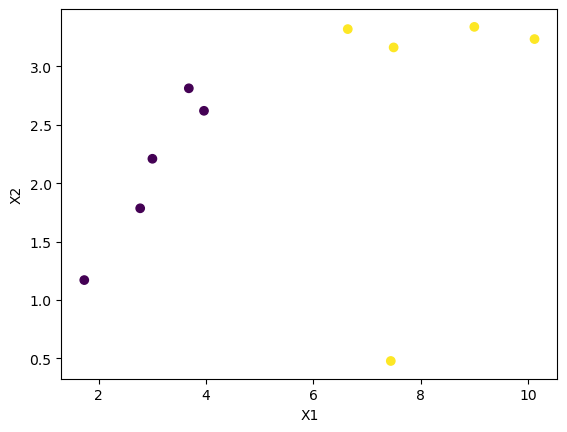

In [27]:
from matplotlib import pyplot as plt

X1 = [2.771244718, 1.728571309, 3.678319846, 3.961043357, 2.999208922, 7.497545867, 9.00220326, 7.444542326, 10.12493903, 6.642287351]
X2 = [1.784783929, 1.169761413, 2.81281357, 2.61995032, 2.209014212, 3.162953546, 3.339047188, 0.476683375, 3.234550982, 3.319983761]
Y = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

plt.scatter(X1, X2, c=Y)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

Clearly, X1=6 is a splitting point.
We see if our code can figure this out.

In [28]:
dataset = [[2.771244718,1.784783929,0],
 [1.728571309,1.169761413,0],
 [3.678319846,2.81281357,0],
 [3.961043357,2.61995032,0],
 [2.999208922,2.209014212,0],
 [7.497545867,3.162953546,1],
 [9.00220326,3.339047188,1],
 [7.444542326,0.476683375,1],
 [10.12493903,3.234550982,1],
 [6.642287351,3.319983761,1]]

best_split_dic = best_split(dataset)
print("X%d = %f" % (best_split_dic['index']+1, best_split_dic['value']))
print("The gini for this split is: %f" %(best_split_dic['gini']))

X1 = 6.642287
The gini for this split is: 0.000000


Running as expected.

To terminal(group) function finds the max occuring class_value in the group and returns it.

In [29]:
def terminal(group):
    outcome = [row[-1] for row in group]
    return max(set(outcome), key= outcome.count)

recursive_split(node, max_height, min_nodes, depth) makes a tree recursively. The 'node' here is a dictionary, that we get from the best_split(dataset).

In [30]:
def recursive_split(node, max_height, min_nodes, depth):
    left, right = node['groups']
    del(node['groups'])

    #check if any side is empty
    if not left or not right:
        node['left'] = node['right'] = terminal(left+right)
        return
    
    #check if maximum depth has been reached
    if depth >= max_height:
        node['left'] = terminal(left)
        node['right'] = terminal(right)
        return

    #check if rows are sufficient in left side
    if len(left) <= min_nodes:
        node['left'] = terminal(left)
    else:
        node['left'] = best_split(left)
        recursive_split(node['left'], max_height, min_nodes, depth+1)
    
    #check if rows are sufficient in right side
    if len(right) <= min_nodes:
        node['right'] = terminal(right)
    else:
        node['right'] = best_split(right)
        recursive_split(node['right'], max_height, min_nodes, depth+1)
    
    return

Note that node['right'] is a class_value when it is a terminal and a dictionary when it is an internal node or root node. Same for node['left'].

The build_tree(dataset, max_height, min_nodes) builds a descision tree and returns its root, which is always a dictionary.

In [31]:
def build_tree(dataset, max_height, min_nodes):
    root = best_split(dataset)
    recursive_split(root, max_height, min_nodes, 1)
    return root

In [32]:
def print_tree(node, depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
		print_tree(node['left'], depth+1)
		print_tree(node['right'], depth+1)
	else:
		print('%s[%s]' % ((depth*' ', node)))

Checking how all this works with the same simple dataset.

In [33]:
dataset = [[2.771244718,1.784783929,0],
	[1.728571309,1.169761413,0],
	[3.678319846,2.81281357,0],
	[3.961043357,2.61995032,0],
	[2.999208922,2.209014212,0],
	[7.497545867,3.162953546,1],
	[9.00220326,3.339047188,1],
	[7.444542326,0.476683375,1],
	[10.12493903,3.234550982,1],
	[6.642287351,3.319983761,1]]
tree = build_tree(dataset, 3, 1)
print_tree(tree)

[X1 < 6.642]
 [X1 < 2.771]
  [0]
  [X1 < 2.771]
   [0]
   [0]
 [X1 < 7.498]
  [X1 < 7.445]
   [1]
   [1]
  [X1 < 7.498]
   [1]
   [1]


Predicting the set of new datapoint.

The function predict(datapoint, node) takes the datapoint which has all the attributes in a list, and the root node (initially) and prints the predicted class.

In [34]:
def predict(datapoint, node):
    #if it is not a terminal node
    if isinstance(node, dict):
        if datapoint[node['index']] < node['value']:
            return predict(datapoint, node['left'])
        else:
            return predict(datapoint, node['right'])
    
    #when it is a terminal node
    else:
        return node

In [35]:
tree = build_tree(dataset, 1, 1)
print_tree(tree)
datapoint = [6.9,2.81281357]
print(predict(datapoint, tree))

[X1 < 6.642]
 [0]
 [1]
1


Good. It is working as expected. Now we will try to apply it to a real dataset and see how predictions work.

First I have to load, preprocess and then convert the titanic dataset into list of lists form.

In [36]:
import pandas as pd

df_titanic = pd.read_csv('database/titanic_train.csv')
df_titanic = df_titanic.drop(['Ticket', 'Embarked', 'Name', 'Cabin', 'PassengerId'], axis=1)

from sklearn.preprocessing import OrdinalEncoder
ordinalencoder = OrdinalEncoder()
df_titanic[['Sex']] = ordinalencoder.fit_transform(df_titanic[['Sex']])
df_titanic = df_titanic.dropna(how = 'any')

survived = df_titanic['Survived']
df_titanic = df_titanic.drop(['Survived'], axis=1)
df_titanic['Survived'] = survived
df_titanic.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,3,1.0,22.0,1,0,7.2500,0
1,1,0.0,38.0,1,0,71.2833,1
2,3,0.0,26.0,0,0,7.9250,1
3,1,0.0,35.0,1,0,53.1000,1
4,3,1.0,35.0,0,0,8.0500,0


In [37]:
#our code for the decision tree takes input in the form of list of lists. So we will convert the df into that
list_titanic = df_titanic.values.tolist()
print(list_titanic[1])

[1.0, 0.0, 38.0, 1.0, 0.0, 71.2833, 1.0]


In [38]:
tree_titanic = build_tree(list_titanic, 20, 100)
# print_tree(tree_titanic)

The accuracy function calculates the accuracy of our model.

In [39]:
def accuracy(tree, dataset, expected_outcome):
    correct = 0
    for index in range(len(dataset)):
        if predict(dataset[index], tree) == expected_outcome[index]:
            correct +=1
    
    return correct/(len(dataset))

In [40]:
print(accuracy(tree_titanic, list_titanic, [row[-1] for row in list_titanic]))

0.8165266106442577


Now loading the test dataset and seeing how it goes.

In [41]:
df_titanic_test = pd.read_csv('database/titanic_test.csv')
df_titanic_test = df_titanic_test.drop(['Ticket', 'Embarked', 'Name', 'Cabin', 'PassengerId'], axis=1)

df_titanic_test[['Sex']] = ordinalencoder.transform(df_titanic_test[['Sex']])
df_titanic_test = df_titanic_test.dropna(how = 'any')

print(df_titanic_test.head())

titanic_Y_test = pd.read_csv('database/titanic_test_survived.csv')
titanic_Y_test = titanic_Y_test.drop(['PassengerId'], axis=1)
print(titanic_Y_test.head())

list_titanic_test = df_titanic_test.values.tolist()
print(list_titanic_test[0])

list_titanic_Y_test = titanic_Y_test.values
print(list_titanic_Y_test)

   Pclass  Sex   Age  SibSp  Parch     Fare
0       3  1.0  34.5      0      0   7.8292
1       3  0.0  47.0      1      0   7.0000
2       2  1.0  62.0      0      0   9.6875
3       3  1.0  27.0      0      0   8.6625
4       3  0.0  22.0      1      1  12.2875
   Survived
0         0
1         1
2         0
3         0
4         1
[3.0, 1.0, 34.5, 0.0, 0.0, 7.8292]
[[0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]

In [44]:
tree_titanic = build_tree(list_titanic, 10, 2000)
print(accuracy(tree_titanic, list_titanic, [row[-1] for row in list_titanic]))
print(accuracy(tree_titanic, list_titanic_test, [row[0] for row in list_titanic_Y_test]))


0.7801120448179272
0.5709969788519638
